In [1]:
import lmfit as lm
import matplotlib.pyplot as plt
from pinem import Pinem
import numpy as np
from tqdm import tqdm

In [2]:
test_file = np.load('./datasets/test_model_pinem_amp1000_bkgd0.1_nort_seed42.npz')
test_data = test_file['data']

In [3]:
test_data.shape

(2500, 1024)

In [18]:
x = np.linspace(-20,20,1024) # Here I recommend 1024 instaed of 1000
amplitude = 100
kernel = 'Gaussian'
n_cutoff = 50
background = 0.1
n = 64

p = Pinem(x, amplitude, n_cutoff, kernel)

params = lm.Parameters()
params.add('omega', value=1.4, min = 0.5, vary = False)
params.add('g', value=1.5, min = 0.0)
params.add('offset', value=-2.0)
params.add('fwhm', value=0.85, min = 0.3, vary = False)
params.add('rt', value=0.7, min = 0.3, vary = False)
params.add('background', value=0.1, min = 0.01, vary = False)
params.add('amplitude', value=1000, min = 0.0, vary = False)


def residual(pars, p, data=None):
    # unpack parameters: extract .value attribute for each parameter
    omega = pars['omega'].value
    g = pars['g'].value
    offset = pars['offset'].value
    fwhm = pars['fwhm'].value
    rt = pars['rt'].value
    background = pars['background'].value
    amplitude = pars['amplitude'].value
    #print(omega, g, offset, fwhm, rt, background)
    model = p.calc_sq_modulus(omega, g, offset, fwhm, rt)
    Mmodel, mmodel = np.max(model), np.min(model)
    nmodel =(model - mmodel)/(Mmodel - mmodel)
    fmodel = nmodel * amplitude + background*amplitude

    if data is None:
        return fmodel

    return fmodel - data



In [17]:
results = []
for i in tqdm(test_data[:200]) :
    result = lm.minimize(residual, params,args = (p,), kws = {'data' : i}, method = 'leastsq')
    results.append(result)

100%|██████████| 200/200 [01:30<00:00,  2.21it/s]


In [19]:
diff_1 = np.zeros((200,))
# diff_2 = np.zeros((600,))
for i,r in enumerate(results) : 
    diff_1[i] = test_file['truth'][i,0] - r.params['g'].value
    # diff_2[i] = test_file['truth'][i,1] - r.params['rt'].value

In [20]:
np.mean(diff_1), np.std(diff_1)#, np.mean(diff_2), np.std(diff_2)

(-0.4009429727710938, 1.0064858919978612)

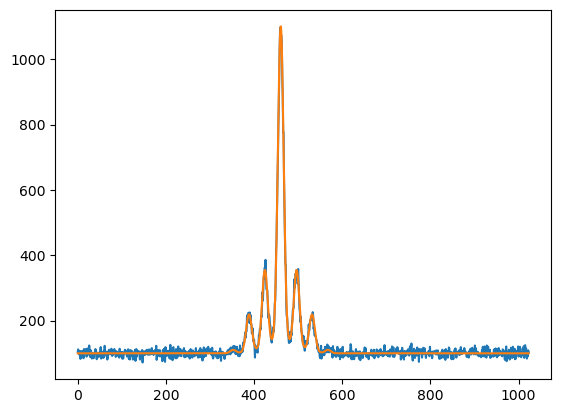

In [23]:
n = 25
plt.plot(test_data[n])
list_var = [results[n].params[r].value for r in results[n].var_names]
plt.plot(residual(results[n].params, p))

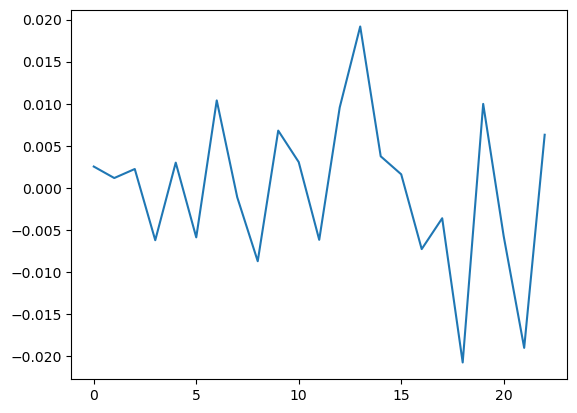

In [29]:
plt.plot(diff_1[18:41])
# plt.plot(diff_2)

In [28]:
np.std(diff_1[18:40])

0.00913581793765008